In [1]:
# Import essential libraries
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import os

# Check if CUDA is available
print("Is CUDA available:", torch.cuda.is_available())

# Check how many GPUs are available
print("Number of GPUs:", torch.cuda.device_count())

# If CUDA is available, print the name of the first GPU
for i in range(torch.cuda.device_count()):
    print("GPU Name:", torch.cuda.get_device_name(i))


Is CUDA available: True
Number of GPUs: 2
GPU Name: NVIDIA GeForce RTX 2080 Ti
GPU Name: NVIDIA GeForce RTX 2080 Ti


In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Alle CSV-Dateien laden
trials = os.listdir("csv/cuttet")
trials_data = [pd.read_csv(f"csv/cuttet/{trial}") for trial in trials]

# Die Spalten mit den XYZ-Daten auswählen
xyz_columns = [col for col in trials_data[0].columns if '(mm)' in col]

# Alle Daten zusammenfassen, um eine globale Skalierung durchzuführen
all_xyz_data = np.vstack([df[xyz_columns].values for df in trials_data])

# Normalisierung der Daten auf den Bereich [0, 1]
scaler = MinMaxScaler()
scaler.fit(all_xyz_data)

# Funktion zur Normalisierung und Skalierung der Daten
def normalize_and_scale(df, scaler, xyz_columns):
    df[xyz_columns] = scaler.transform(df[xyz_columns].values)
    return df

# Anwenden der Normalisierung auf alle Trials
normalized_data = [normalize_and_scale(df, scaler, xyz_columns).dropna() for df in trials_data]

# Daten in einen großen DataFrame zusammenfassen
full_data = pd.concat(normalized_data, ignore_index=True)


In [3]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Features und Zielwerte
features = full_data.drop(columns=['Frame', 'Sub Frame'])
targets = features.shift(-1).dropna()  # Nächste Position als Zielwert

features = features.iloc[:-1]
features_tensor = torch.tensor(features.values, dtype=torch.float32)
targets_tensor = torch.tensor(targets.values, dtype=torch.float32)

# Dataset und DataLoader für PyTorch
dataset = TensorDataset(features_tensor, targets_tensor)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [4]:
features

,Tasch:shoulder:X (mm),Tasch:shoulder:Y (mm),Tasch:shoulder:Z (mm),Tasch:shoulderElbowSupport:X (mm),Tasch:shoulderElbowSupport:Y (mm),Tasch:shoulderElbowSupport:Z (mm),Tasch:elbow:X (mm),Tasch:elbow:Y (mm),Tasch:elbow:Z (mm),Tasch:wrist:X (mm),...,Tasch:elbowWrist:Z (mm),Tasch:outerKnuckle:X (mm),Tasch:outerKnuckle:Y (mm),Tasch:outerKnuckle:Z (mm),Tasch:thumbKnuckle:X (mm),Tasch:thumbKnuckle:Y (mm),Tasch:thumbKnuckle:Z (mm),Tasch:thumbTip:X (mm),Tasch:thumbTip:Y (mm),Tasch:thumbTip:Z (mm)
0,0.883789,0.081452,0.257111,0.814640,0.236289,0.231913,0.674507,0.355683,0.174446,0.547351,...,0.086339,0.546003,0.259468,0.057253,0.531924,0.218383,0.003481,0.502618,0.384352,0.009127
1,0.885581,0.079686,0.251252,0.814789,0.233875,0.221959,0.675455,0.355055,0.170530,0.548811,...,0.083668,0.546361,0.256659,0.051557,0.532637,0.217398,0.003103,0.503511,0.385330,0.007637
2,0.887193,0.077769,0.246607,0.816986,0.233896,0.212005,0.676364,0.353575,0.166668,0.548874,...,0.079715,0.547025,0.254246,0.048555,0.533528,0.216551,0.001643,0.504144,0.385730,0.006256
3,0.889046,0.076684,0.241474,0.819989,0.236566,0.215584,0.677111,0.352773,0.162717,0.548630,...,0.077923,0.547353,0.252195,0.046649,0.533752,0.215567,0.001200,0.504381,0.386159,0.007214
4,0.890329,0.076131,0.237255,0.822265,0.237810,0.218693,0.677651,0.350100,0.158931,0.548582,...,0.077897,0.547227,0.252068,0.047663,0.533577,0.214786,0.002322,0.504411,0.386288,0.006771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8943,0.135005,0.987429,0.585957,0.116854,0.973219,0.536201,0.091687,0.910438,0.463762,0.047226,...,0.360826,0.041594,0.387424,0.218508,0.041507,0.024590,0.228751,0.031974,0.054856,0.285185
8944,0.135653,0.985556,0.587100,0.118723,0.972434,0.533529,0.094296,0.909767,0.462560,0.048149,...,0.356669,0.042328,0.387091,0.219538,0.042348,0.021190,0.231535,0.032380,0.052984,0.291285
8945,0.136746,0.983711,0.589855,0.121357,0.971375,0.534907,0.096689,0.908865,0.461860,0.049266,...,0.358165,0.043120,0.387580,0.217752,0.043302,0.019621,0.237624,0.033644,0.052732,0.297366
8946,0.137675,0.981870,0.592696,0.122987,0.969654,0.538585,0.098123,0.908462,0.460151,0.050761,...,0.362440,0.043593,0.388303,0.220522,0.044664,0.019719,0.242061,0.035002,0.052372,0.299275


In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define LSTM-based Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h, _ = self.lstm(x)
        out = self.fc(h[:, -1, :])  # Use the last time step
        return out

# Prepare sequence data
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10  # Number of past frames to use for predicting the next frame
X, y = create_sequences(features_tensor.numpy(), seq_length)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Dataset and DataLoader
dataset = TensorDataset(X, y)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Model parameters
input_size = X.shape[2]  # Number of features per time step
hidden_size = 64
output_size = y.shape[1]

# Initialize model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 50
for epoch in range(epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')



Epoch 1/50, Loss: 0.0020745915826410055
Epoch 2/50, Loss: 0.0008994071977213025
Epoch 3/50, Loss: 0.0005000891978852451
Epoch 4/50, Loss: 0.0003728212905116379
Epoch 5/50, Loss: 0.00026392657309770584
Epoch 6/50, Loss: 0.00028841590392403305
Epoch 7/50, Loss: 0.000223755108891055
Epoch 8/50, Loss: 0.000188688951311633
Epoch 9/50, Loss: 0.0002482464478816837
Epoch 10/50, Loss: 0.00017125670274253935
Epoch 11/50, Loss: 0.00013556632620748132
Epoch 12/50, Loss: 0.00015320377133321017
Epoch 13/50, Loss: 0.00034329594927839935
Epoch 14/50, Loss: 0.00017127431055996567
Epoch 15/50, Loss: 0.00015340253594331443
Epoch 16/50, Loss: 8.609712676843628e-05
Epoch 17/50, Loss: 9.841332939686254e-05
Epoch 18/50, Loss: 9.548703383188695e-05
Epoch 19/50, Loss: 0.00012527369835879654
Epoch 20/50, Loss: 0.00026481287204660475
Epoch 21/50, Loss: 0.00012564094504341483
Epoch 22/50, Loss: 0.00016354005492758006
Epoch 23/50, Loss: 0.000235807616263628
Epoch 24/50, Loss: 7.67053134040907e-05
Epoch 25/50, Loss

In [46]:

# Predicting a path
model.eval()
with torch.no_grad():
    predicted_path = []
    input_seq = X[0:1]  # Start with the first sequence in the test set
    for _ in range(10000):
        pred = model(input_seq)
        predicted_path.append(pred.numpy().flatten())
        next_input = torch.cat((input_seq[:, 1:, :], pred.unsqueeze(1)), dim=1)
        input_seq = next_input

# Convert predicted path to DataFrame
predicted_data = pd.DataFrame(predicted_path, columns=features.columns)
predicted_data[xyz_columns] = scaler.inverse_transform(predicted_data[xyz_columns])

# Adding Frame and Sub Frame columns
predicted_data.insert(0, 'Frame', range(1, len(predicted_data) + 1))
predicted_data.insert(1, 'Sub Frame', 0)

# Save as CSV
predicted_data.to_csv('predicted_path_lstm.csv', index=False)
print("Predicted path saved as 'predicted_path_lstm2.csv'.")

Predicted path saved as 'predicted_path_lstm2.csv'.


In [41]:
import pandas as pd
import torch

# Nehmen wir an, das Modell ist bereits trainiert und wir haben ein Anfangs-Frame
# Nehmen wir den ersten Frame des Datasets als Startpunkt
initial_frame = features_tensor[0:1]  # Erster Frame als Startpunkt

# Anzahl der Frames, die wir vorhersagen möchten (z.B. 100)
num_frames = 1000

# Speicher für die vorhergesagten Frames
predicted_frames = []

# Kopiere den ersten Frame in die Liste
predicted_frames.append(initial_frame.numpy().flatten())

# Vorhersage der Bahn
current_input = initial_frame
for _ in range(num_frames - 1):  # Minus 1, da wir schon den ersten Frame haben
    with torch.no_grad():
        next_frame = model(current_input)
        predicted_frames.append(next_frame.numpy().flatten())
        current_input = next_frame  # Das vorhergesagte Frame als neues Input nutzen

# Umwandeln der Vorhersagen in einen DataFrame
predicted_data = pd.DataFrame(predicted_frames, columns=features.columns)


In [42]:
# Rücktransformation der normalisierten Daten in den ursprünglichen Bereich
predicted_data[xyz_columns] = scaler.inverse_transform(predicted_data[xyz_columns])

# Hinzufügen von Frame und Sub Frame (oder wir können einfach Frame als Index verwenden)
predicted_data.insert(0, 'Frame', range(1, num_frames + 1))
predicted_data.insert(1, 'Sub Frame', 0)  # Setze Sub Frame auf 0, wenn nicht anders benötigt


In [43]:

predicted_data

,Frame,Sub Frame,Tasch:shoulder:X (mm),Tasch:shoulder:Y (mm),Tasch:shoulder:Z (mm),Tasch:shoulderElbowSupport:X (mm),Tasch:shoulderElbowSupport:Y (mm),Tasch:shoulderElbowSupport:Z (mm),Tasch:elbow:X (mm),Tasch:elbow:Y (mm),...,Tasch:elbowWrist:Z (mm),Tasch:outerKnuckle:X (mm),Tasch:outerKnuckle:Y (mm),Tasch:outerKnuckle:Z (mm),Tasch:thumbKnuckle:X (mm),Tasch:thumbKnuckle:Y (mm),Tasch:thumbKnuckle:Z (mm),Tasch:thumbTip:X (mm),Tasch:thumbTip:Y (mm),Tasch:thumbTip:Z (mm)
0,1,0,398.292999,-83.202499,482.288483,333.968018,0.702237,331.562988,283.942993,70.150200,...,112.478004,193.639999,263.406006,31.036100,79.541115,239.671997,29.548498,44.480587,283.157013,17.736401
1,2,0,400.741211,-83.735817,482.060516,336.071228,0.723200,331.008545,283.742981,69.076241,...,111.091797,197.022614,262.211700,30.175631,80.286583,238.785324,29.383713,55.530342,282.798035,17.844116
2,3,0,402.782959,-84.309715,481.735596,337.461731,0.293705,330.606689,284.908630,68.139259,...,110.304733,198.476364,260.987030,29.752048,84.147156,238.181747,29.163208,60.610783,282.624084,18.084990
3,4,0,404.604797,-84.979004,481.416595,338.933960,-0.199363,330.280212,285.947174,67.257492,...,109.767281,199.825867,259.873718,29.531601,87.070396,237.758865,28.814859,63.827576,282.413116,18.315088
4,5,0,406.273315,-85.695641,481.125641,340.384430,-0.663875,330.008667,286.970306,66.446877,...,109.360817,201.062164,258.859070,29.445927,89.205963,237.435745,28.380459,66.023338,282.130035,18.509186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,0,458.649292,-91.469292,450.249023,373.850647,-5.539711,308.380829,295.286194,62.422768,...,104.905670,171.846252,256.126648,26.617702,57.524586,228.648499,34.110989,24.247675,276.303406,27.972361
996,997,0,459.010315,-91.583038,450.177063,374.219208,-5.581236,308.345490,295.701813,62.428715,...,104.905907,172.231064,256.068146,26.714926,57.905128,228.622528,34.099186,24.752903,276.240692,27.933889
997,998,0,459.359589,-91.687073,450.110779,374.573975,-5.616210,308.313995,296.100372,62.438206,...,104.906776,172.597961,256.012482,26.806719,58.266804,228.596313,34.087433,25.230501,276.180267,27.898045
998,999,0,459.697266,-91.781639,450.049957,374.915283,-5.644984,308.286072,296.482574,62.450825,...,104.908241,172.947723,255.959564,26.893324,58.609844,228.569885,34.075687,25.681341,276.122284,27.864727


In [44]:
# Speichern des DataFrames als CSV
predicted_data.to_csv('predicted_path.csv', index=False)

print("Predicted path saved as 'predicted_path.csv'.")


Predicted path saved as 'predicted_path.csv'.


In [2]:
# Load the dataset from CSV
df = pd.read_csv('csv/processed_Trajectories.csv')

# Extract relevant features (shoulder, elbow, wrist) and target (thumb_tip)
shoulder = df[['Tasch:shoulder:X (mm)', 'Tasch:shoulder:Y (mm)', 'Tasch:shoulder:Z (mm)']].values
elbow = df[['Tasch:elbow:X (mm)', 'Tasch:elbow:Y (mm)', 'Tasch:elbow:Z (mm)']].values
wrist = df[['Tasch:wrist:X (mm)', 'Tasch:wrist:Y (mm)', 'Tasch:wrist:Z (mm)']].values
triangle2 = df[['Tasch:Triangle2:X (mm)','Tasch:Triangle2:Y (mm)','Tasch:Triangle2:Z (mm)']].values
triangle1 = df[['Tasch:Triangle1:X (mm)','Tasch:Triangle1:Y (mm)','Tasch:Triangle1:Z (mm)']].values
thumb_tip = df[['Tasch:ThumbTip: (mm)', 'Tasch:ThumbTip:Y (mm)', 'Tasch:ThumbTip:Z (mm)']].values

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()

# Concatenate the input features (shoulder, elbow, wrist) and scale them together
X_all = np.vstack([shoulder, elbow, wrist])
X_all_scaled = scaler.fit_transform(X_all)

# Split back into shoulder, elbow, and wrist after scaling
shoulder = X_all_scaled[:len(shoulder)]
elbow = X_all_scaled[len(shoulder):len(shoulder) + len(elbow)]
wrist = X_all_scaled[len(shoulder) + len(elbow):]

# Scale the target (thumb_tip) separately
thumb_tip = scaler.fit_transform(thumb_tip)

# Combine features (shoulder, elbow, wrist) into the input (X)
X = np.hstack([shoulder, elbow, wrist])
Y = thumb_tip

# Split the data into training and validation sets (80% train, 20% validation)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f"Training input shape: {X_train.shape}, Validation input shape: {X_val.shape}")

Training input shape: (38311, 9), Validation input shape: (9578, 9)


In [3]:
# Define the imitation learning model
class ImitationModel(nn.Module):
    def __init__(self):
        super(ImitationModel, self).__init__()
        # Define the layers of the model
        self.fc1 = nn.Linear(X_train.shape[1], 64)  # Input layer
        self.fc2 = nn.Linear(64, 64)  # Hidden layer
        self.fc3 = nn.Linear(64, 3)   # Output layer (predicting X, Y, Z of ThumbTip)

    def forward(self, x):
        # Define the forward pass
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
# Initialize the model and move it to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")
model = ImitationModel().to(device)
print(model)


Using Device: cuda
ImitationModel(
  (fc1): Linear(in_features=9, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
)


In [4]:
# Define the loss function (Mean Squared Error for regression tasks)
criterion = nn.MSELoss()

# Define the optimizer (Adam Optimizer for adjusting weights during training)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert the training and validation data to PyTorch tensors and move them to GPU
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32).to(device)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
Y_val_tensor = torch.tensor(Y_val, dtype=torch.float32).to(device)

print("Data prepared for training and validation.")


Data prepared for training and validation.


Epoch [10/100], Training Loss: 0.1697, Validation Loss: 0.1576
Epoch [20/100], Training Loss: 0.0652, Validation Loss: 0.0584
Epoch [30/100], Training Loss: 0.0350, Validation Loss: 0.0352
Epoch [40/100], Training Loss: 0.0286, Validation Loss: 0.0277
Epoch [50/100], Training Loss: 0.0219, Validation Loss: 0.0215
Epoch [60/100], Training Loss: 0.0169, Validation Loss: 0.0165
Epoch [70/100], Training Loss: 0.0132, Validation Loss: 0.0129
Epoch [80/100], Training Loss: 0.0108, Validation Loss: 0.0106
Epoch [90/100], Training Loss: 0.0095, Validation Loss: 0.0094
Epoch [100/100], Training Loss: 0.0088, Validation Loss: 0.0088


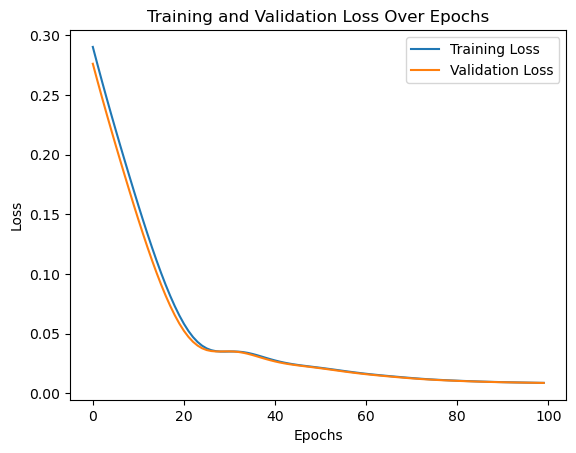

In [5]:
# Number of training epochs
epochs = 100

# Lists to store the loss at each epoch for training and validation
train_losses = []
val_losses = []

# Training loop with validation
for epoch in range(epochs):
    model.train()  # Set model to training mode
    
    optimizer.zero_grad()  # Reset gradients

    # Forward pass: Compute predicted Y by passing X_train to the model
    train_outputs = model(X_train_tensor)
    
    # Compute the training loss
    train_loss = criterion(train_outputs, Y_train_tensor)
    
    # Backward pass: Compute gradients
    train_loss.backward()
    
    # Update the weights using the optimizer
    optimizer.step()

    # Store the training loss for this epoch
    train_losses.append(train_loss.item())
    
    # Set model to evaluation mode for validation
    model.eval()
    with torch.no_grad():
        # Forward pass on the validation set
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, Y_val_tensor)
        val_losses.append(val_loss.item())
    
    # Print the losses every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss.item():.4f}, Validation Loss: {val_loss.item():.4f}")

# Plot the training and validation loss curves
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [6]:
# Set the model to evaluation mode for prediction
model.eval()

# Predict the thumb_tip position using the trained model
with torch.no_grad():
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    predicted_thumb_tip = model(X_train_tensor).cpu().numpy()  # Convert prediction to numpy array for plotting

# Actual vs Predicted ThumbTip Positions
print("Shape of actual thumb_tip:", Y_train.shape)
print("Shape of predicted thumb_tip:", predicted_thumb_tip.shape)


Shape of actual thumb_tip: (38311, 3)
Shape of predicted thumb_tip: (38311, 3)


In [7]:
# Save the trained model to a file
torch.save(model.state_dict(), 'imitation_model.pth')
print("Model saved to imitation_model.pth")


Model saved to imitation_model.pth
